https://www.cienciadedatos.net/documentos/py16-interpretacion-modelos-graficos-pdp-ice.html

**<font size="5">Introducción</font>**

Los gráficos Individual Conditional Expectation (ICE) y Partial Dependence (PDP) muestran cómo varían las predicciones de un modelo de machine learning en función del valor que toma alguno de sus predictores. Además de ser muy útiles para entender la relación entre la variable respuesta y los predictores, permiten diferenciar cuándo dicha relación es aditiva o está afectada por interacciones con otros predictores. También permiten entender cómo se comporta un modelo cuando se extrapola a regiones para las que no se dispone de observaciones.

Los gráficos PDP muestran, con una única curva, cómo varía **en promedio** la predicción de la variable respuesta a medida que se modifica uno de los predictores, manteniendo constante el resto. Los gráficos ICE muestran cómo varía la predicción **para cada una de las observaciones** a medida que se modifica uno de los predictores, manteniendo constante el resto. Son por lo tanto una extensión más detallada de los gráficos PDP.

Tres de las librerías que permiten crear gráficos ICE y PDP en python son sklearn.inspection, PyCEbox y PDPbox.

+ La versión de `scikit-learn 0.23` solo permite la creación de gráficos PDP, la versión `scikit-learn 0.24` (todavía en desarrollo en el momento de escribir este documento) sí permite crear las curvas ICE.


+ La librería `PyCEbox` ya no está mantenida por lo que, aunque muy fácil de utilizar, podría dejar de funcionar con futuras versiones.


+ La librería `PDPbox` está activamente mantenida y permite la creación de múltiples gráficos exploratorios de modelos, entre ellos, PDP e ICE.


A lo largo de este documento se muestran ejemplos de cómo crear e interpretar gráficos ICE y PDP con la librería `PDPbox`.

# Curvas ICE y PDP

El set de datos `Boston` contiene información sobre la mediana del precio en las viviendas de la ciudad de Boston junto con información de las características de las casas y la zona donde se encuentran.

In [1]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Librerías
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from pdpbox import pdp

In [2]:
# Datos
# ==============================================================================
boston = load_boston(return_X_y=False)
datos  = pd.DataFrame(boston.data, columns = boston.feature_names)
datos['MEDV'] = boston.target
datos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Se entrena un modelo de tipo Random Forest con el objetivo de predecir el precio de la vivienda (`MEDV`) en función de todas las demás variables disponibles.

In [3]:
# Modelo
# ==============================================================================
X_train = datos.drop(columns=['MEDV'])
y_train = datos['MEDV']

modelo = RandomForestRegressor(n_estimators=500, max_depth=4)
modelo.fit(
    X_train,
    y_train
)

RandomForestRegressor(max_depth=4, n_estimators=500)

Una vez entrenado el modelo, con las funciones `pdp_isolate()` y `pdp_plot()` del paquete `pdpbox` se pueden obtener los gráficos ICE y PDP de cualquiera los predictores.

La función `pdp_isolate()` crea un dataframe con los valores de cada curva. Sus principales argumentos son:

+ `dataset`: dataframe con el valor de los predictores, normalmente el de los datos de entrenamiento.


+ `feature`: nombre del predictor cuyas curvas ICE se quieren calcular.


+ `model_features`: nombre de todos los predictores del modelo.


+ `model`: modelo entrenado sobre el que se quieren generar las curvas.


+ `num_grid_points`: número de puntos calculados para cada curva ICE. Si el set de datos es muy grande, se recomienda reducirlo.


La función `pdp_plot()` emplea los resultados generados con `pdp_isolate()` para representar el gráfico. Sus principales argumentos son:


+ `pdp_isolate_out`: resultados generados con `pdp_isolate()`.


+ `feature_name`: nombre del predictor cuyas curvas ICE se quieren representar.


+ `frac_to_plot`: fracción de curvas ICE que se muestran en el gráfico.


+ `plot_pts_dist`: si se muestra o no la distribución de las observaciones originales en el conjunto de entrenamiento.


+ `center`: centrar las curvas en cero.

A continuación, se explora la influencia que tiene la antigüedad de la vivienda (`AGE`) sobre el precio de la vivienda (`MEDV`).

In [4]:
# Cálculo curvas ICE
# ==============================================================================
ice_df = pdp.pdp_isolate(
            model   = modelo,
            dataset = X_train,
            feature = 'AGE',
            model_features = X_train.columns,
            num_grid_points=20,
            grid_type='percentile'
        )

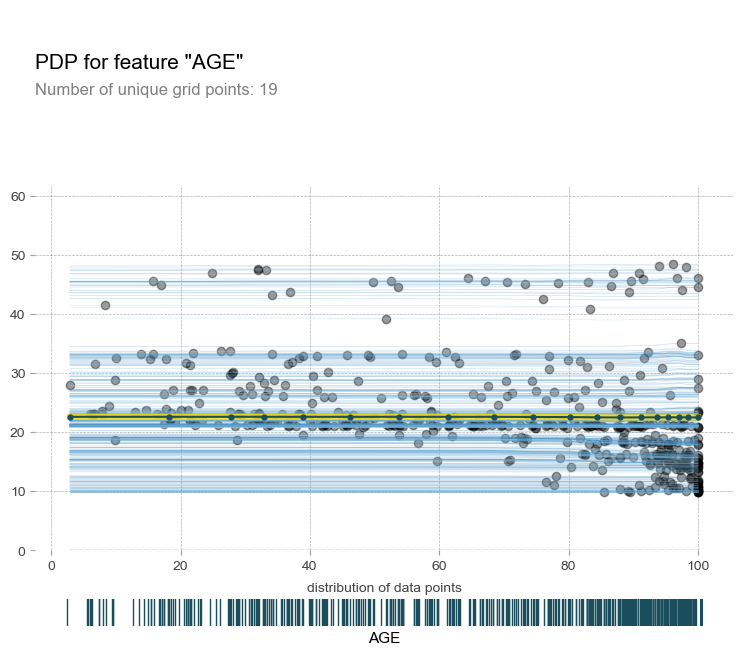

In [5]:
# Gráfico curvas ICE
# ==============================================================================
fig, axes = pdp.pdp_plot(
                ice_df,
                feature_name  = 'AGE',
                center        = False,
                plot_pts_dist = True,
                plot_lines    = True,
                frac_to_plot  = 1,
                x_quantile    = False,
                show_percentile=False,
                figsize       = (9, 8),
                ncols         = 1,
                plot_params   = {'fill_alpha': 0.7},
                which_classes = None,
            )

# Para mostrar el valor real de las observaciones de entrenamiento
axes['pdp_ax']['_pdp_ax'].scatter(
    X_train.AGE,
    modelo.predict(X_train),
    color = 'k',
    alpha = 0.4
)
plt.show();

Cada curva del gráfico anterior (curva ICE) muestra el valor predicho por el modelo para cada observación, conforme se va aumentando el valor de `AGE` y manteniendo constantes el resto de predictores en su valor observado. La curva resaltada en amarillo se corresponde con la curva PDP, que es la variación promedio de todas las observaciones. Además, el gráfico incluye puntos que representan el verdadero valor de `AGE` de cada observación.

La gran mayoría de las curvas son planas, lo que apunta a que, en la mayor parte de los casos, la antigüedad de la vivienda apenas influye en su precio. Sin embargo, puede apreciarse que, unas pocas observaciones, presentan una ligera tendencia de subida o bajada.

# Curvas ICE centradas

Cuando los valores observados de la variable respuesta se acumulan en una región pequeña, el solapamiento de las curvas puede hacer difícil distinguir qué observaciones se escapan de la tendencia general. Para evitar este problema, se puede recurrir a los gráficos ICE centrados (c-ICE). Los gráficos c-ICE se obtienen igual que los gráficos ICE con la única diferencia de que, a cada una de las curvas, se les resta un valor de referencia, normalmente el valor predicho para el mínimo observado del predictor (primer valor de la curva). De esta forma, se consigue que todas las curvas tengan su origen en el 0.

Con esta nueva representación puede observarse con más claridad que, aunque la mayoría de observaciones se mantienen constantes, algunas tienen un claro patrón divergente (para algunas el precio incrementa con la antigüedad y en otras disminuye). Tal y como se describe más adelante, esto suele ser un indicativo de que el predictor `AGE` interacciona con otros predictores.

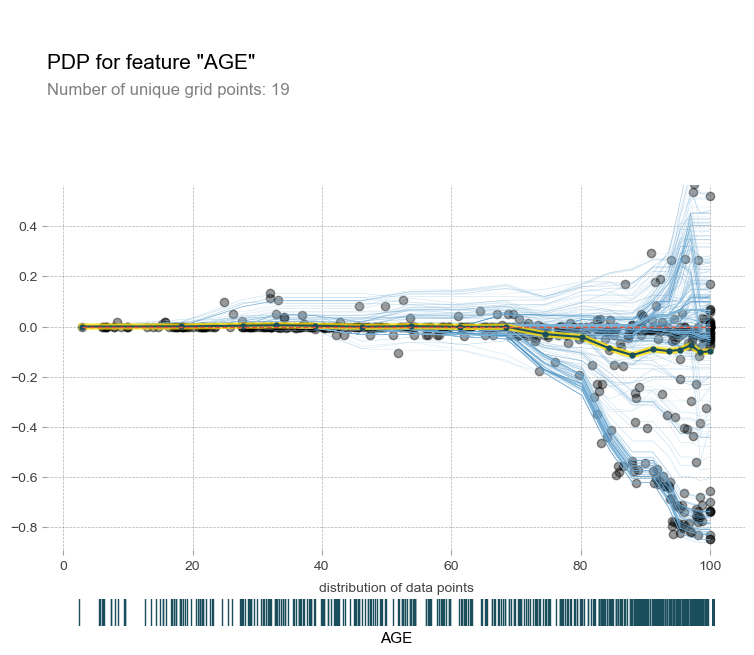

In [6]:
# Gráfico curvas ICE centradas
# ==============================================================================
fig, axes = pdp.pdp_plot(
                ice_df,
                feature_name  = 'AGE',
                center        = True,
                plot_pts_dist = True,
                plot_lines    = True,
                frac_to_plot  = 1,
                x_quantile    = False,
                show_percentile=False,
                figsize       = (9, 8),
                ncols         = 2,
                which_classes = None,
            )

# Para mostrar el valor real de las observaciones de entrenamiento
axes['pdp_ax']['_pdp_ax'].scatter(
    X_train.AGE,
    modelo.predict(X_train) -  ice_df.ice_lines.transpose().iloc[0,:],
    color = 'k',
    alpha = 0.4
)
plt.show();

# Colorear curvas ICE

Como se ha visto en los apartados anteriores, algunas observaciones pueden alejarse de la tendencia general del modelo. Una forma de conseguir información extra que permita comprender las razones de estos patrones divergentes, es colorear las curvas de cada observación (o los puntos de cada observación) en función de otro factor.

Por ejemplo, se colorean los puntos en función de una nueva variable binaria que indique si el número de habitaciones de la vivienda está por encima o por debajo de la mediana.

In [7]:
# Color de cada observación
# ==============================================================================
mediana_habitaciones = np.median(X_train.RM)
colores = np.where(X_train.RM > mediana_habitaciones, 'b', 'r')

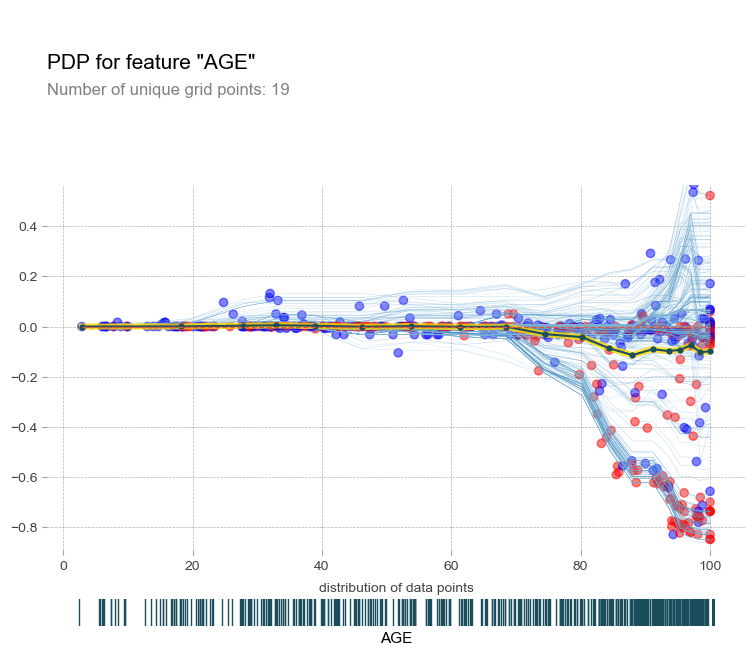

In [8]:
# Gráfico curvas ICE centradas
# ==============================================================================
fig, axes = pdp.pdp_plot(
                ice_df,
                feature_name  = 'AGE',
                center        = True,
                plot_pts_dist = True,
                plot_lines    = True,
                frac_to_plot  = 1,
                x_quantile    = False,
                show_percentile=False,
                figsize       = (9, 8),
                ncols         = 2,
                which_classes = None,
            )

# Para mostrar el valor real de las observaciones de entrenamiento
# coloreadas en función de la nueva clasificación
axes['pdp_ax']['_pdp_ax'].scatter(
    X_train.AGE,
    modelo.predict(X_train) -  ice_df.ice_lines.transpose().iloc[0,:],
    color = colores,
    alpha = 0.5
)
plt.show();

Gracias a los colores puede verse claramente que, para viviendas con un número de habitaciones por encima de la mediana (azul), la antigüedad de la vivienda está asociada positivamente con el precio. Para viviendas con un número de habitaciones inferior a la media, ocurre lo contrario.

# Interacción entre predictores

En la introducción de este documento se menciona que la diferencia entre los gráficos ICE y los PDP es que ,los segundos, muestran una única curva creada con el promedio de todas las curvas ICE. La ventaja de los gráficos ICE queda patente cuando existe interacción entre predictores o cuando no todas las observaciones siguen una misma tendencia. Véase el siguiente ejemplo ilustrativo.

<img src="imagenes\12_Graficos ICE y PDP\00_Ecuaciones.PNG" width="750">

In [9]:
# Librerías
# ==============================================================================
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

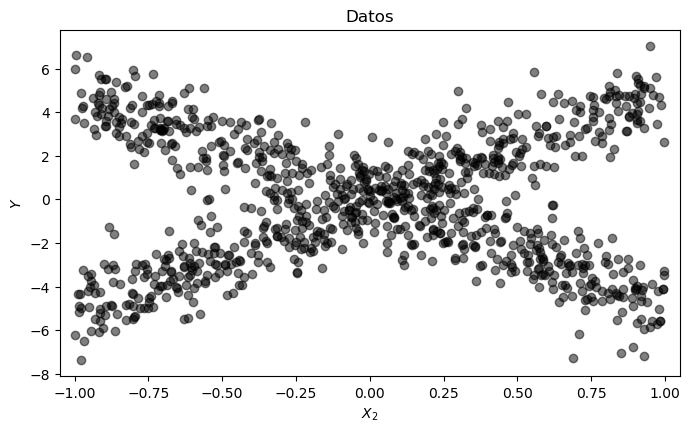

In [10]:
# Datos simulados
# ==============================================================================
N = 1000

df = pd.DataFrame(
        sp.stats.uniform.rvs(-1, 2, size=(N, 3)),
        columns=['x1', 'x2', 'x3']
     )

noise = sp.stats.norm.rvs(size=N)

y = 0.2 * df.x1 - 5 * df.x2 + 10 * df.x2 * (df.x3 >= 0) + noise

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.scatter(df.x2, y, c='k', alpha=0.5)
ax.set_xlim(-1.05, 1.05);
ax.set_xlabel('$X_2$')
ax.set_ylabel('$Y$')
ax.set_title('Datos')
plt.show();

Se entrena un modelo Gradient Boosting para predecir  Y  en función de las 3 variables disponibles.

In [11]:
# Modelo
# ==============================================================================
modelo = GradientBoostingRegressor()
modelo.fit(df.values, y)

GradientBoostingRegressor()

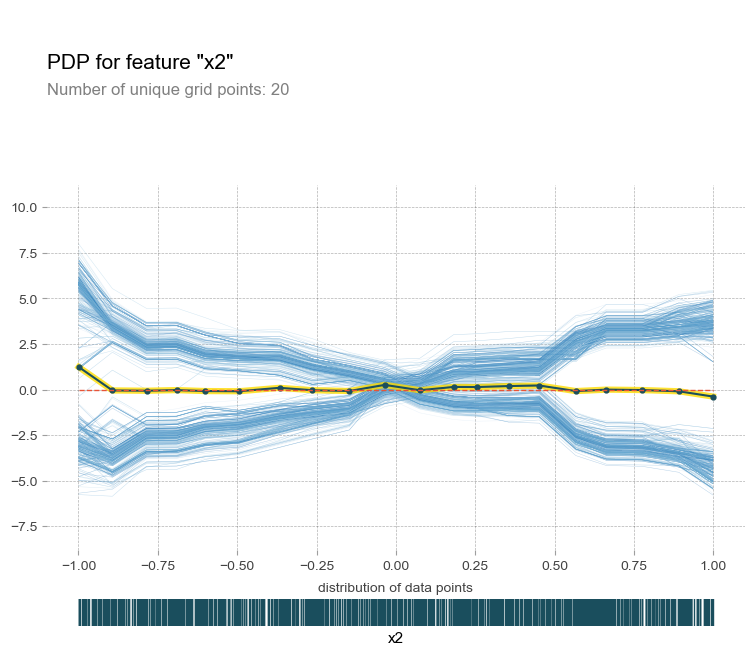

In [12]:
# Gráfico curvas ICE
# ==============================================================================

ice_df = pdp.pdp_isolate(
            model   = modelo,
            dataset = df,
            feature = 'x2',
            model_features = df.columns,
            num_grid_points=20,
            grid_type='percentile'
        )

fig, axes = pdp.pdp_plot(
                ice_df,
                feature_name  = 'x2',
                center        = False,
                plot_pts_dist = True,
                plot_lines    = True,
                frac_to_plot  = 1,
                x_quantile    = False,
                show_percentile=False,
                figsize       = (9, 8),
                ncols         = 1,
                plot_params   = {'fill_alpha': 0.7},
                which_classes = None,
            )
plt.show()

Viendo únicamente la curva PDP (amarillo), podría asumirse que, la variable respuesta, apenas varía en función del valor que tome el predictor  X2 . Esta interpretación puede llevar a conclusiones erróneas ya que, el promedio, está ocultando el verdadero comportamiento individual de las observaciones.